<a href="https://colab.research.google.com/github/AsmaMora/Customer_Analytics/blob/main/MADT8101_Customer_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustomer Segmentation & Product recommendation

A distribution company which sales various health product and has 5 service locations in Asia would like to reach out to their customers more effectively by increasing personalized transactions, improve brand loyalty and customer life time value by performing

1. **Customer segmentation** to reach out customers more effectively
2. **Product recommendation** to boost revenue and engagement by sending personalized message

### Data understaning
1. Sales transaction from 2021 - 2023 (2,404,316 rows)

Data dictionary
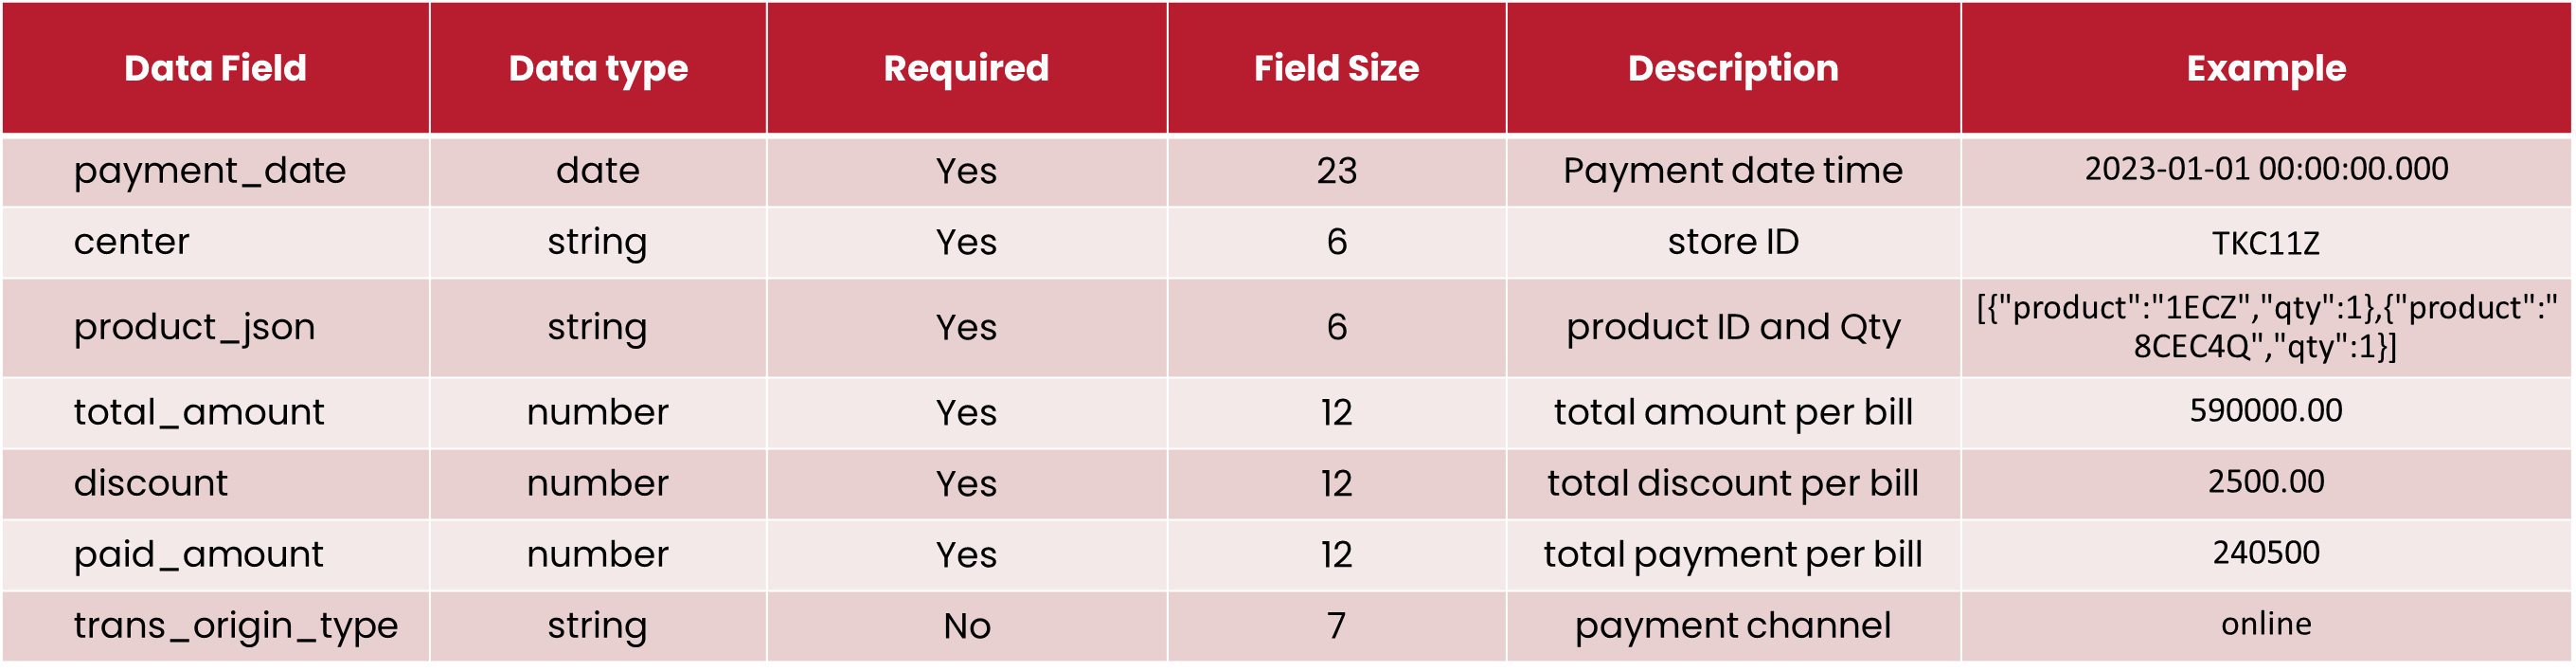

2. Data member (590,565 rows)

Data dictionary
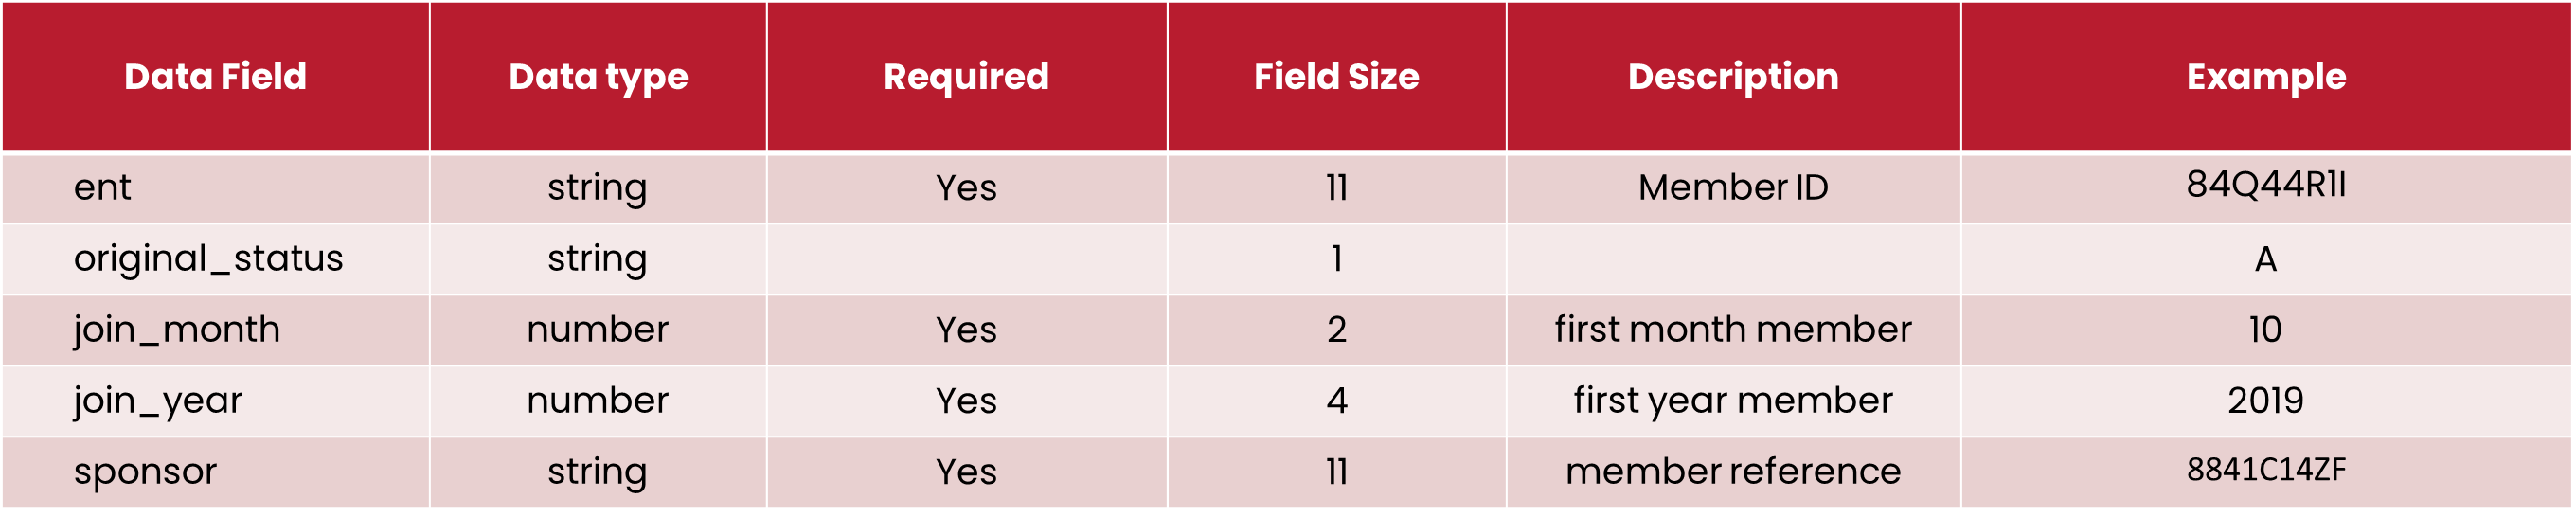

### Sanity Check

#### Sales transaction
1. **Missing value** Total rows of the data set are 2,406,316 rows and have null value in columns total_amt, product_json, discount and paid_amt

  Clean data: Remove row which have null in column total, amt and product_json
2. I**ncomplete dataset** From the sales transaction tables, we found the missing data in Y2021 from M6 – M12

  Clean data: Exclude Y2021 for the dataset used to develop the model

3. **Special data characteristic**  There is a specially formatted column in column name product_json. The column has data in json format that includes the products and the quantity purchased for each transaction

  Clean data: Split the column to display 1 product per column and quantity of each product

4. **Incorrect format** There is incorrect data format in column payment_date

  Clean data: Convert to date time format

5. **Lack of essential data** No. price per product and member of each customer

  Clean data:
    
    - Product price Calculation by mathematic formula
    1. Transaction which contain one product

      Price(A) = Total amount / Qty.

    2. Transaction which contain more than one product

    Price(B) = (Total amount – (Price(A) x Qty(A)) / Qty(B)

  - Member of each customer mapping from data member

### Assumption

1. Focus on total amount by ignoring paid amount because there are only 50K members were paid more than zero from total customer around 578K members
2. Using data from the most recent two months in 2023, recommend a product in each cluster.

### Data transformation
#### Customer single view
Summarize sales transaction data to display customer single view and use to develop customer clustering model.

**Ideation**
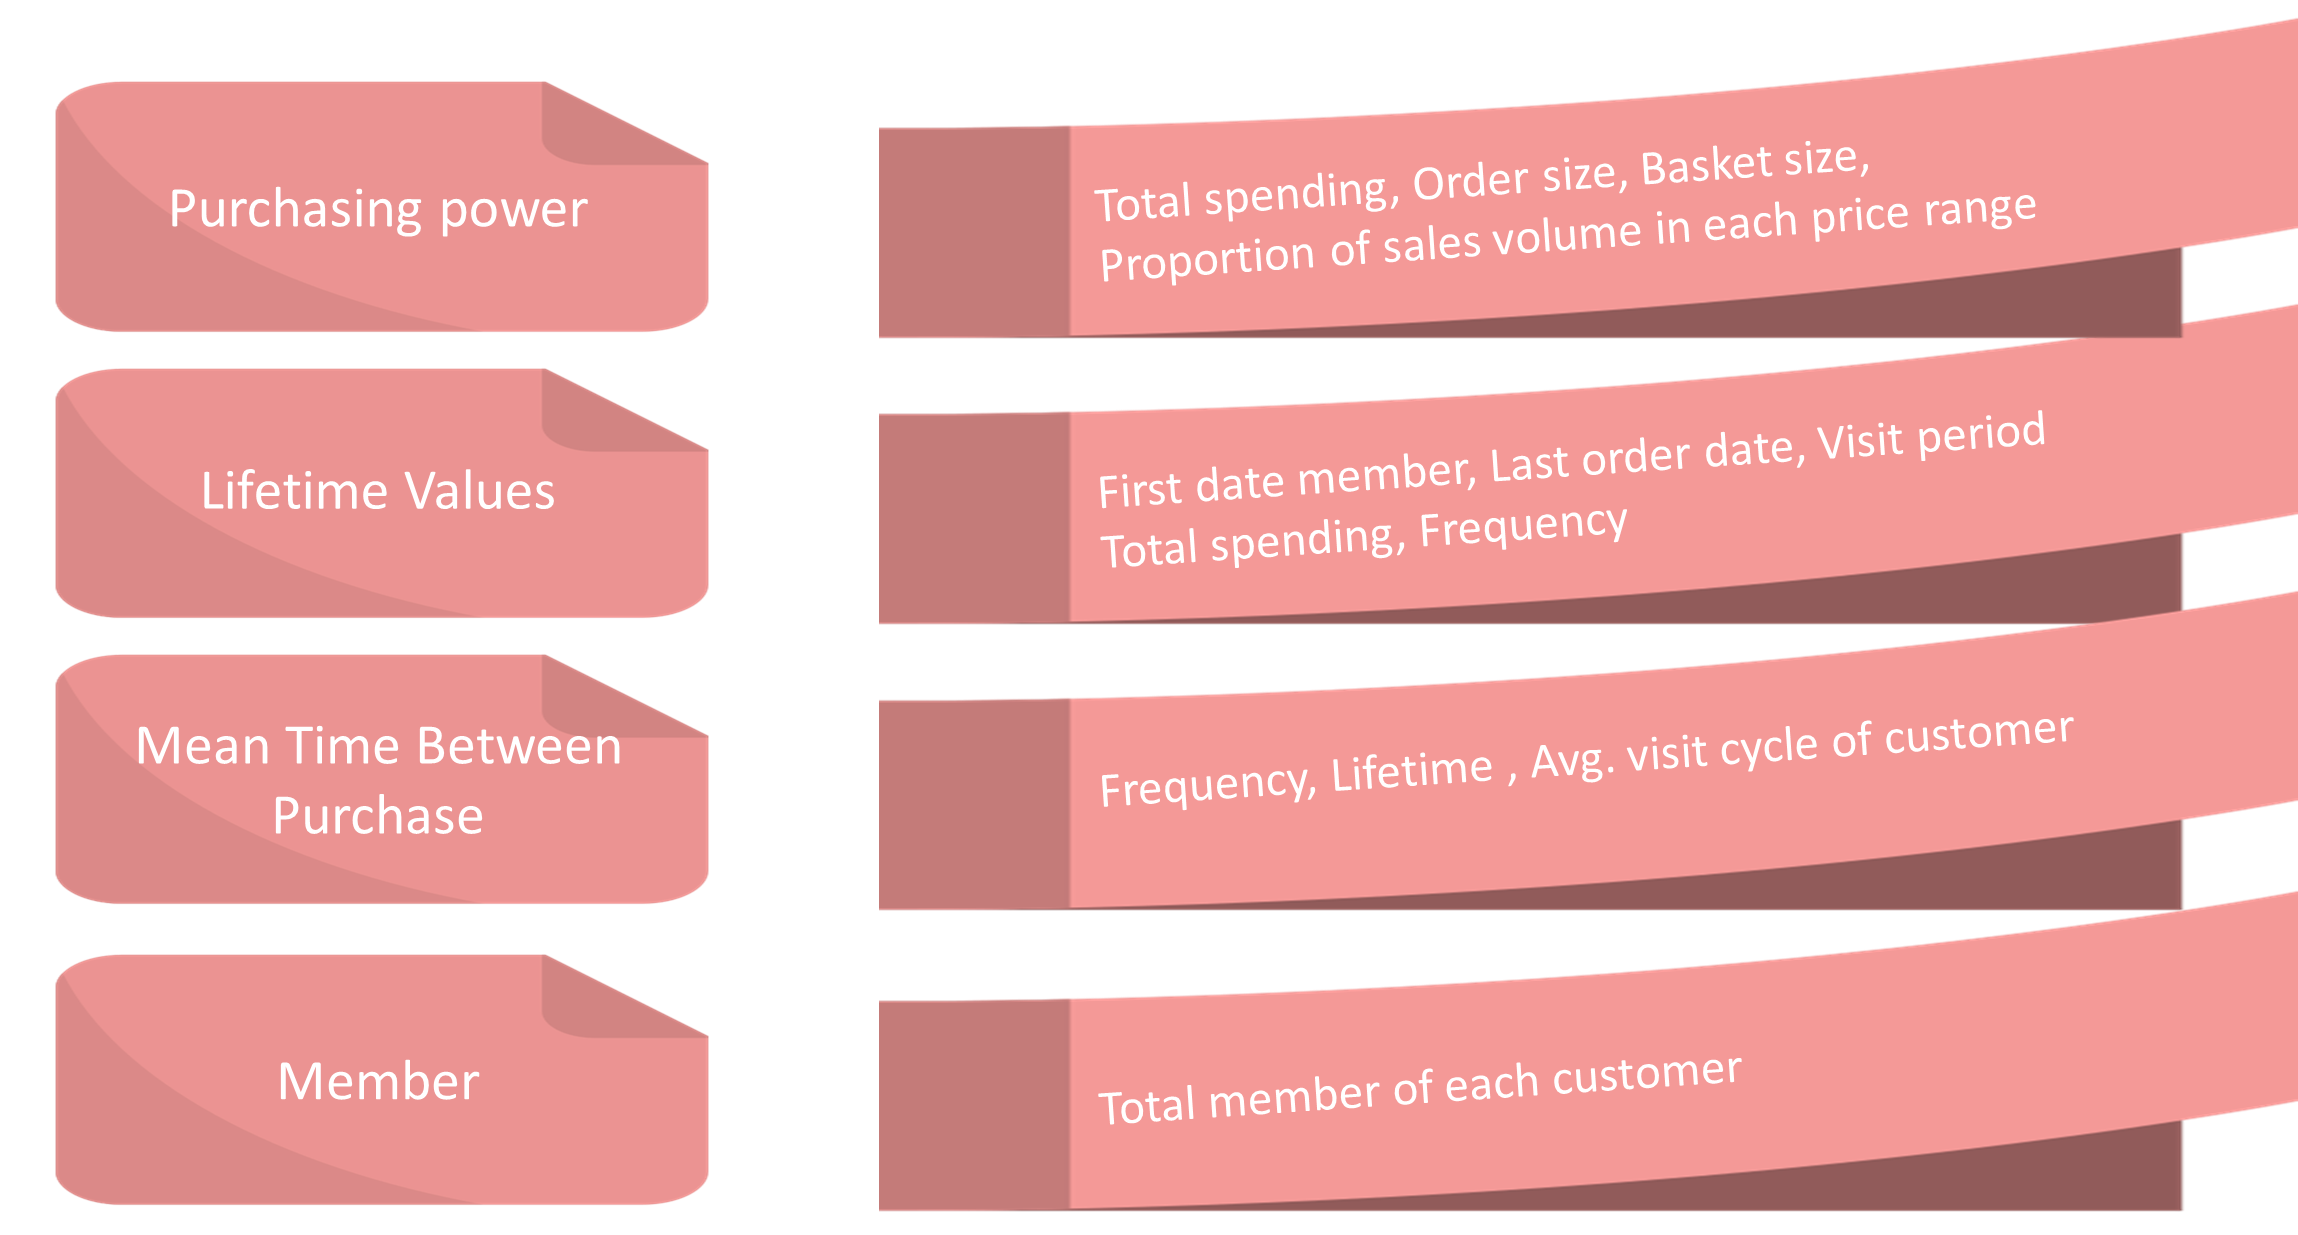

**Data dictionary**
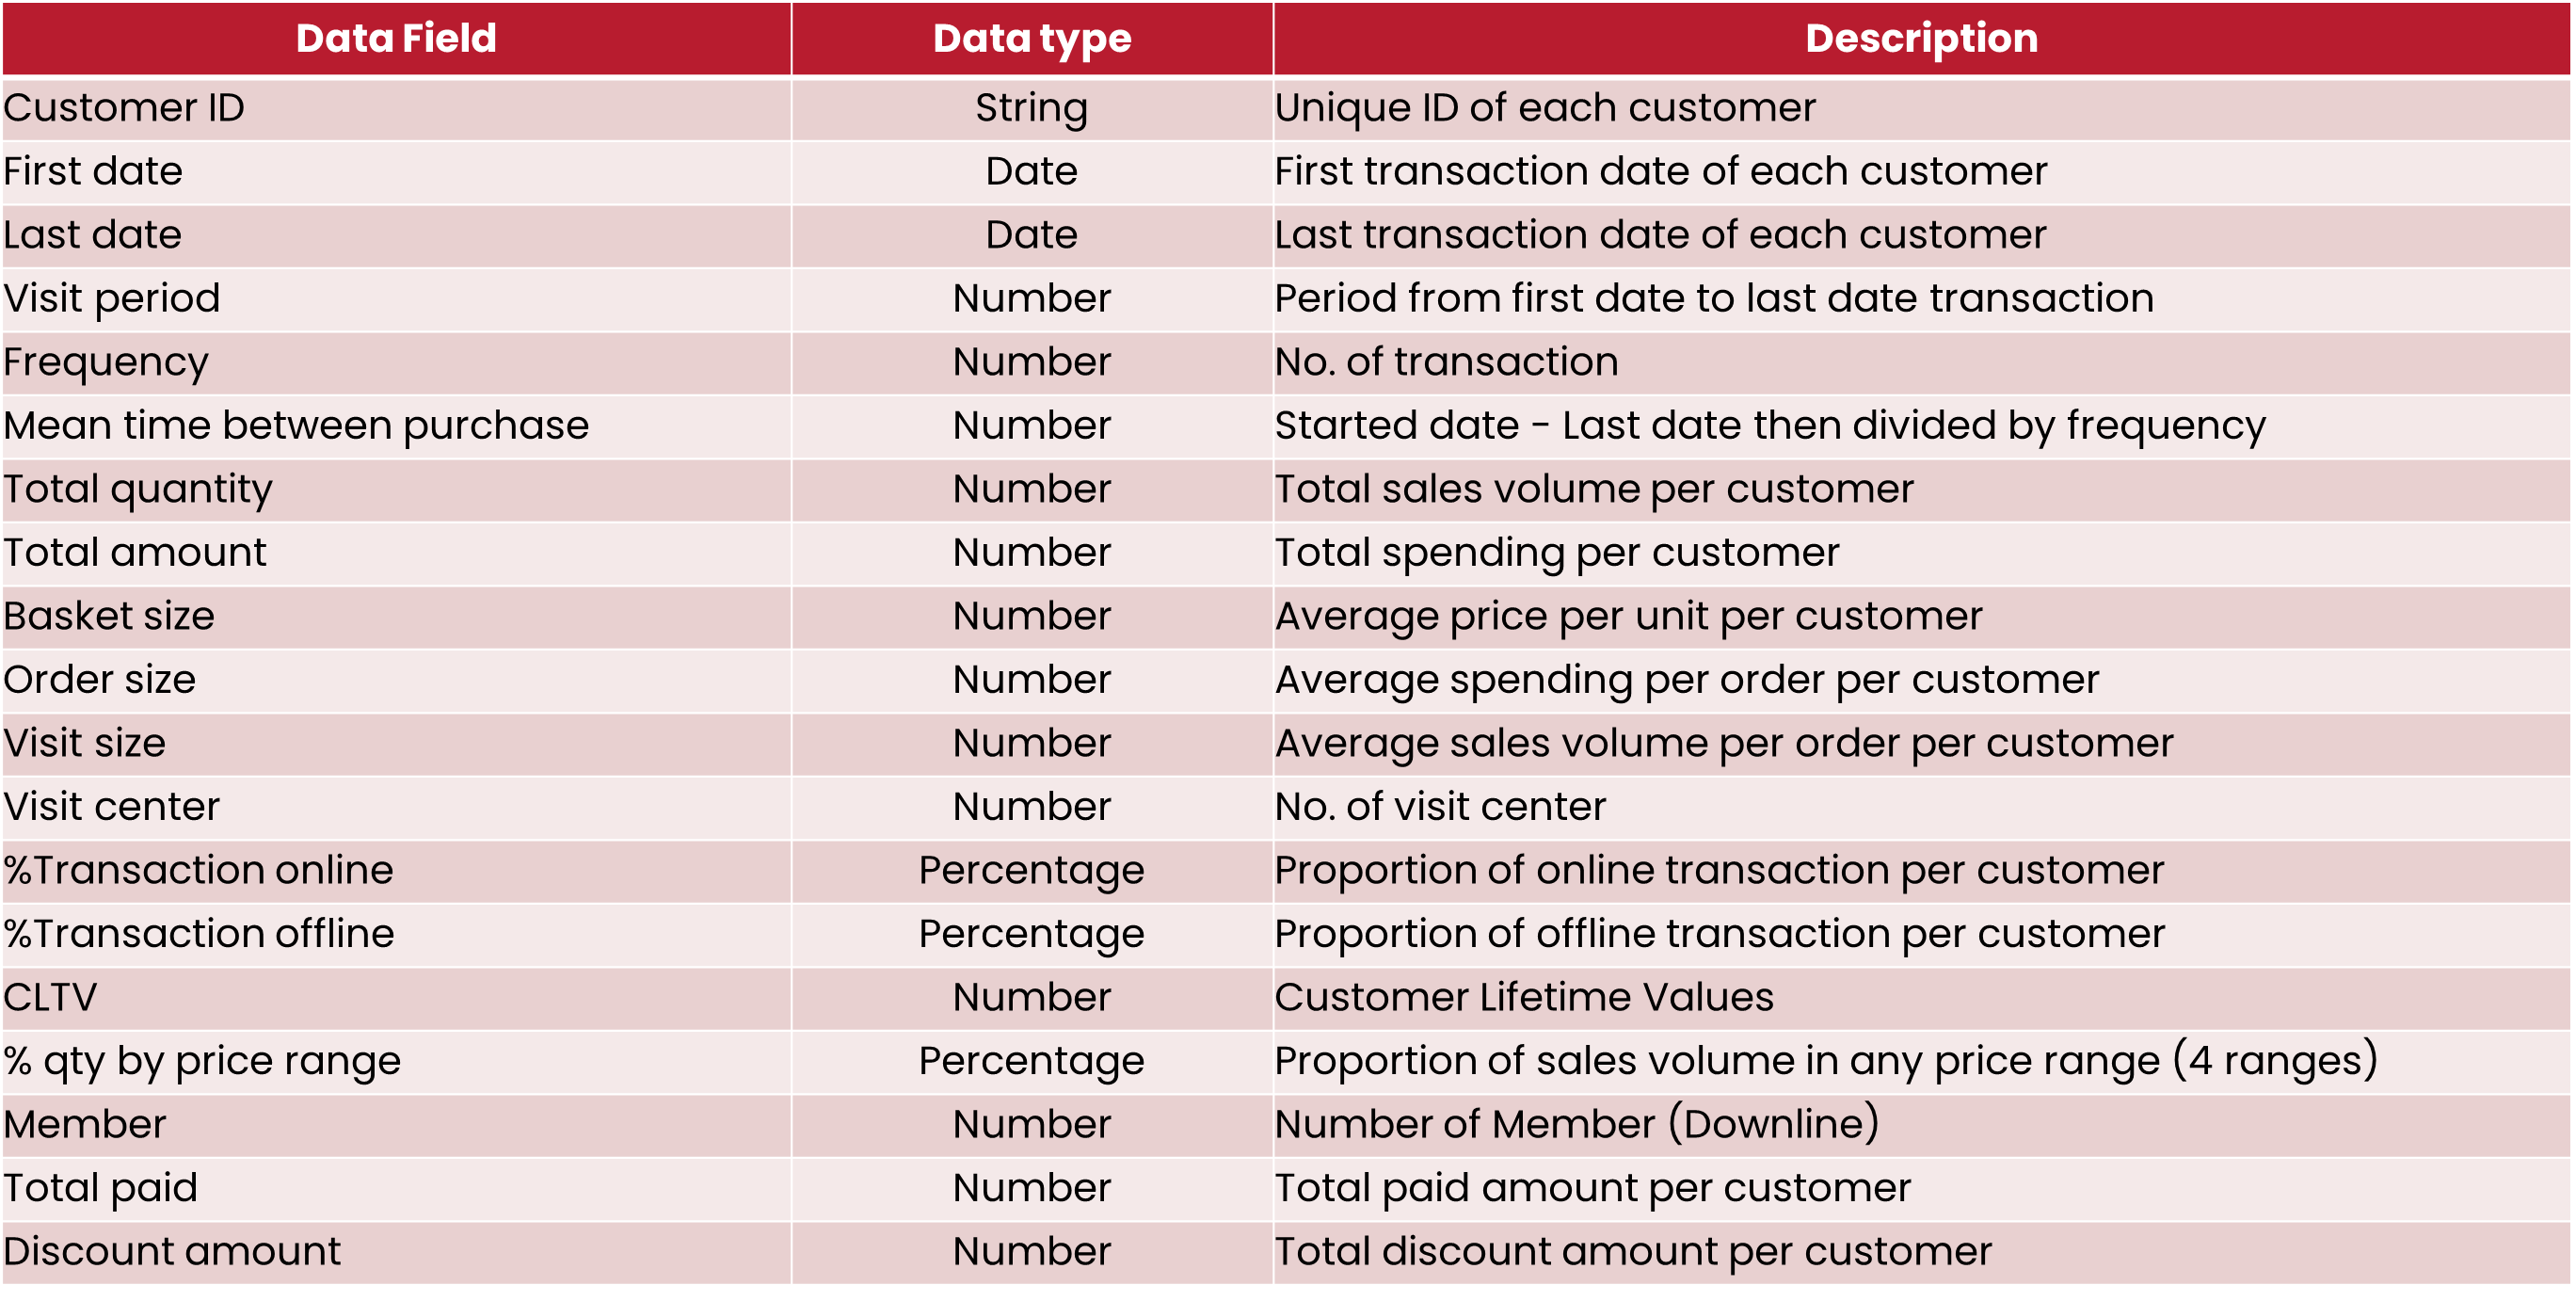

#### Unpivot data product

Transform sales transaction data by unpivoting product and quantity columns of each transaction to rows.

### Customer segmentation

Using customer single view to develop customer segmentation

In [ ]:
%pip install pycaret

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [4]:
import pandas as pd

df0 = pd.read_parquet('https://github.com/AsmaMora/Customer_Analytics/raw/main/Data/customer_feature_2022.01.01_2023.07.parquet')

In [ ]:
df = df0

In [ ]:
df = df.fillna(0)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 578091 entries, 0 to 578090
Data columns (total 25 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   ent             578091 non-null  object        
 1   first_date      578091 non-null  datetime64[ns]
 2   last_date       578091 non-null  datetime64[ns]
 3   total_qty       578091 non-null  int64         
 4   total_amt       578091 non-null  int64         
 5   no.visit        578091 non-null  int64         
 6   basket_size     578091 non-null  float64       
 7   join_date       578091 non-null  object        
 8   no.join_year    578091 non-null  int64         
 9   visit_period    578091 non-null  int64         
 10  MTBP            578091 non-null  int64         
 11  order_size      578091 non-null  float64       
 12  visit_size      578091 non-null  float64       
 13  no.center       578091 non-null  int64         
 14  ARPU            578091 non-null  flo

In [ ]:
df.describe()

,total_qty,total_amt,no.visit,basket_size,no.join_year,visit_period,MTBP,order_size,visit_size,no.center,...,trans_online,trans_offline,CLTV,trans_price_Q1,trans_price_Q2,trans_price_Q3,trans_price_Q4,no.end_under,total_paid,disc_amt
count,578091.000000,5.780910e+05,578091.000000,5.780910e+05,578091.000000,578091.000000,578091.000000,5.780910e+05,578091.000000,578091.000000,...,578091.000000,578091.000000,5.780910e+05,578091.000000,578091.000000,578091.000000,578091.000000,578091.000000,5.780910e+05,5.780910e+05
mean,10.009552,3.475580e+06,3.550078,5.084364e+05,44.746258,102.091468,17.039227,1.173222e+06,2.803533,1.739972,...,0.465537,0.561436,7.083903e+08,0.288643,0.289475,0.253988,0.167894,0.789689,1.864826e+05,1.042002e+05
std,108.749139,6.937046e+06,7.488334,3.543186e+05,58.389070,221.035127,39.398434,6.338836e+05,2.348601,1.728079,...,0.439013,0.434846,5.029009e+08,0.262117,0.297982,0.295598,0.282248,4.916385,1.012379e+06,3.560275e+05
min,1.000000,2.500000e+03,1.000000,2.500000e+03,0.000000,0.000000,0.000000,2.500000e+03,1.000000,1.000000,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
25%,2.000000,1.559000e+06,1.000000,2.925000e+05,1.000000,0.000000,0.000000,6.946000e+05,1.500000,1.000000,...,0.000000,0.000000,3.293578e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
50%,4.000000,1.690000e+06,2.000000,4.128000e+05,2.000000,1.000000,1.000000,1.119667e+06,2.166667,1.000000,...,0.500000,0.625000,6.371890e+08,0.250000,0.250000,0.166667,0.000000,0.000000,0.000000e+00,0.000000e+00
75%,8.000000,2.341000e+06,3.000000,5.850000e+05,124.000000,47.000000,14.000000,1.630000e+06,3.600000,2.000000,...,1.000000,1.000000,9.996951e+08,0.500000,0.500000,0.447368,0.250000,0.000000,0.000000e+00,2.000000e+04
max,44546.000000,1.646114e+08,682.000000,4.380000e+06,124.000000,916.000000,457.000000,4.654750e+07,420.245283,74.000000,...,1.000000,1.000000,4.161346e+10,1.000000,1.000000,1.000000,1.000000,1008.000000,5.010950e+07,1.202250e+07


In [ ]:
# Drop column
df_features = df.drop(['ent'], axis=1)
df_features = df_features.drop(['first_date'], axis=1)
df_features = df_features.drop(['last_date'], axis=1)
df_features = df_features.drop(['join_date'], axis=1)
df_features = df_features.drop(['total_paid'], axis=1)
#df_features = df_features.drop(['disc_amt'], axis=1)
#df_features = df_features.drop(['no.end_under'], axis=1)
df_features = df_features.drop(['trans_price_Q1'], axis=1)
df_features = df_features.drop(['trans_price_Q2'], axis=1)
df_features = df_features.drop(['trans_price_Q3'], axis=1)
#df_features = df_features.drop(['no.center'], axis=1)
df_features = df_features.drop(['no.join_year'], axis=1)
df_features = df_features.drop(['trans_offline'], axis=1)
df_features = df_features.drop(['trans_online'], axis=1)

In [ ]:
# Standardize the features
scaler = StandardScaler()
df_features_scaled = scaler.fit_transform(df_features)

#### Find the optimal number of clusters

Elbow Method to determine the number of clusters to be formed:


C:\Users\mindy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\mindy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\mindy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\mindy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\mindy\anaconda3\lib\site-packages\sklearn\clust

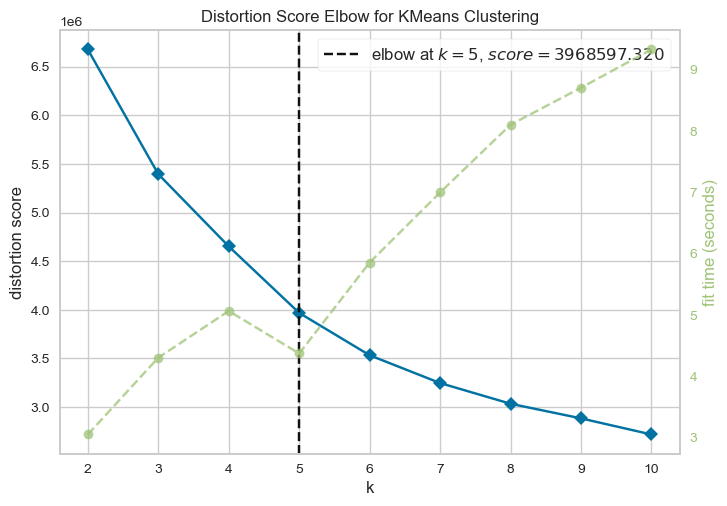

In [ ]:
# Quick examination of elbow method to find numbers of clusters to make.
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(random_state=158), k=10, scoere='calinski_harabasz')
Elbow_M.fit(df_features_scaled)
Elbow_M.show();

C:\Users\mindy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\mindy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\mindy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\mindy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Window

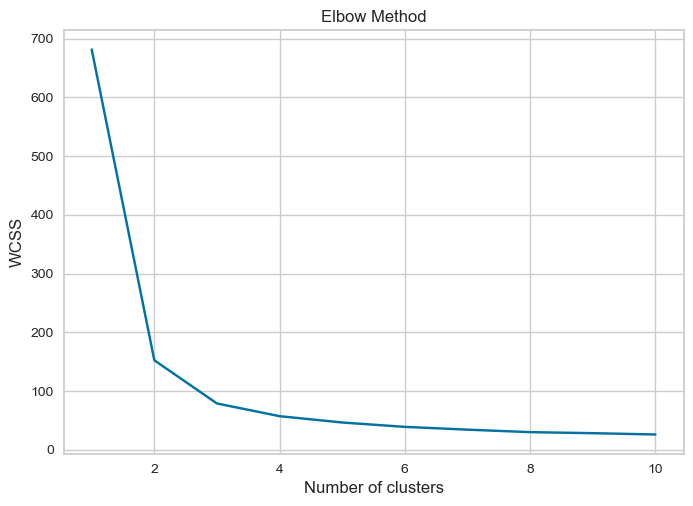

In [ ]:
# Finding the optimal number of clusters using Elbow Method
#
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [ ]:
from sklearn import datasets
from sklearn.cluster import KMeans

# Load IRIS dataset
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Instantiate the KMeans models
km = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)

# Fit the KMeans model
km.fit_predict(X)

# Calculate Silhoutte Score
score = silhouette_score(X, km.labels_, metric='euclidean')

# Print the score
print('Silhouetter Score: %.3f' % score)

C:\Users\mindy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Silhouetter Score: 0.553


C:\Users\mindy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\mindy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\mindy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\mindy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Window

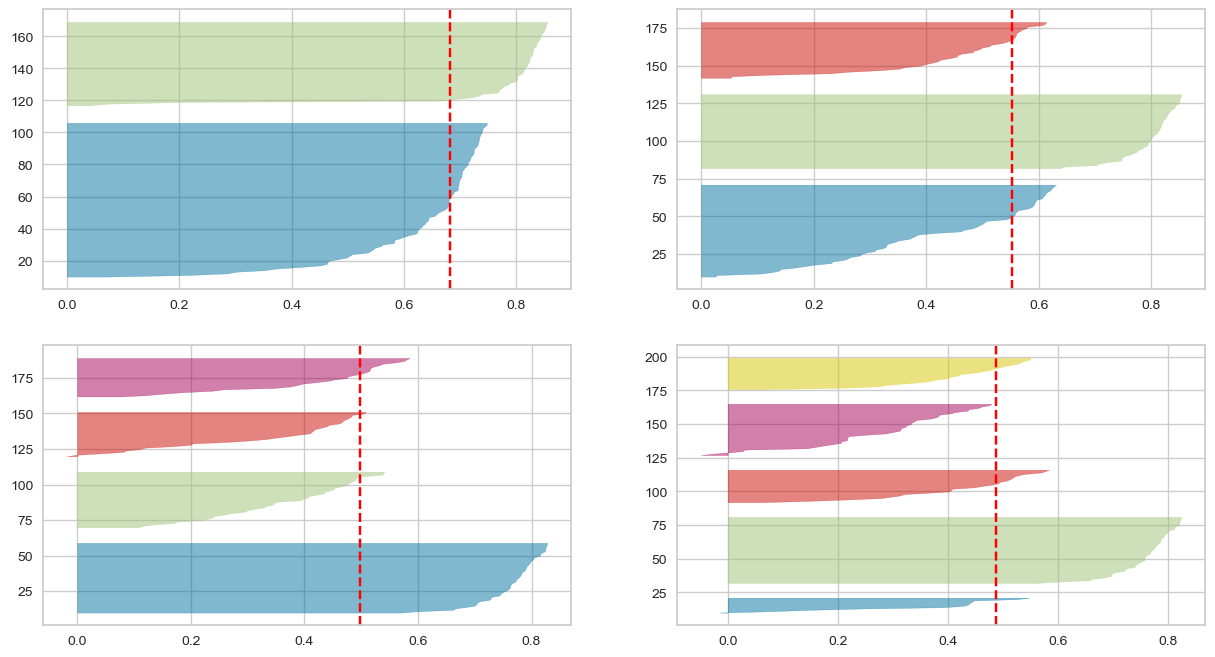

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [2, 3, 4, 5]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)

#### Fit & Predict the model

In [ ]:
# Initiating the K-means Clustering model
KM = KMeans(n_clusters=3, random_state=666)

In [ ]:
# Fit model and predict clusters
yhat_KM = KM.fit_predict(df_features_scaled)

C:\Users\mindy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
# create a new column in the scaled dataframe with the cluster labels
df_features_scaled = pd.DataFrame(df_features_scaled, columns=df_features.columns)
df_features_scaled["Clusters"] = pd.Series(yhat_KM, index=df_features_scaled.index)

In [ ]:
# Adding the Clusters feature to the original dataframe.
df["Clusters"] = df_features_scaled["Clusters"]

#### Principle Component Analysis

In [ ]:
#Initiating PCA to reduce dimentions aka features to 2
pca = PCA(n_components=2)
pca.fit(df_features_scaled)
PCA_ds = pd.DataFrame(pca.transform(df_features_scaled), columns=(["PC1","PC2"]))
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
PC1,578091.0,-1.219286e-17,2.030599,-11.043214,-0.883482,-0.465878,0.113998,103.988289
PC2,578091.0,-4.562490e-17,1.840770,-3.636342,-1.453781,-0.019929,1.385745,118.303038


In [ ]:
PCA_ds["Clusters"] = yhat_KM

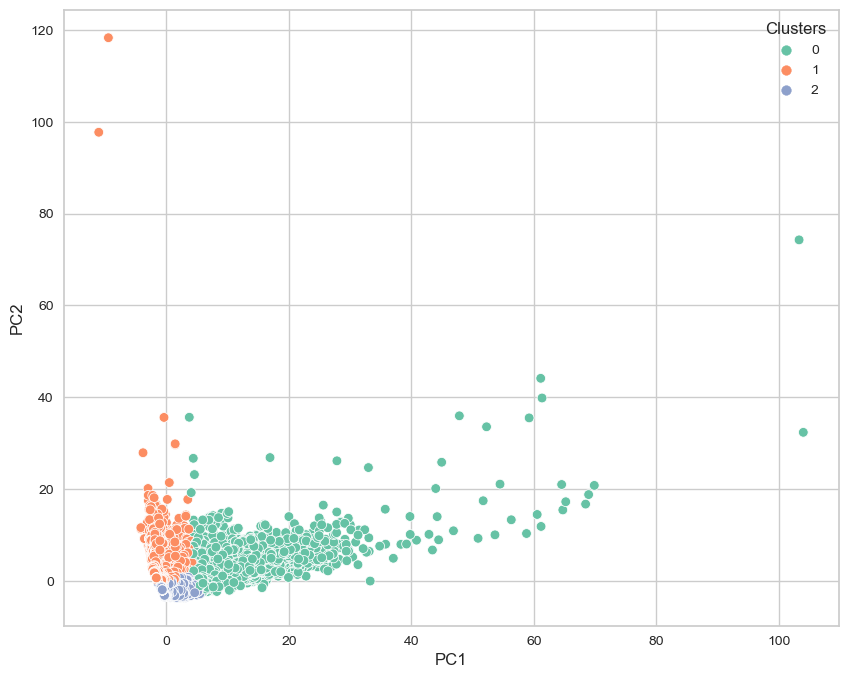

In [ ]:
# Plot the clusters on reduced dimension data
plt.figure(figsize=(10,8))
sns.scatterplot(x="PC1", y="PC2", hue="Clusters", data=PCA_ds, palette="Set2")
plt.show()

In [ ]:
cluster_results = df

In [ ]:
cluster_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 578091 entries, 0 to 578090
Data columns (total 26 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   ent             578091 non-null  object        
 1   first_date      578091 non-null  datetime64[ns]
 2   last_date       578091 non-null  datetime64[ns]
 3   total_qty       578091 non-null  int64         
 4   total_amt       578091 non-null  int64         
 5   no.visit        578091 non-null  int64         
 6   basket_size     578091 non-null  float64       
 7   join_date       578091 non-null  object        
 8   no.join_year    578091 non-null  int64         
 9   visit_period    578091 non-null  int64         
 10  MTBP            578091 non-null  int64         
 11  order_size      578091 non-null  float64       
 12  visit_size      578091 non-null  float64       
 13  no.center       578091 non-null  int64         
 14  ARPU            578091 non-null  flo

In [ ]:
sku_count = cluster_results.groupby('Clusters')['ent'].nunique()
print(sku_count)

Clusters
0     16388
1    261875
2    299828
Name: ent, dtype: int64


In [ ]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 578091 entries, 0 to 578090
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   total_qty       578091 non-null  int64  
 1   total_amt       578091 non-null  int64  
 2   no.visit        578091 non-null  int64  
 3   basket_size     578091 non-null  float64
 4   visit_period    578091 non-null  int64  
 5   MTBP            578091 non-null  int64  
 6   order_size      578091 non-null  float64
 7   visit_size      578091 non-null  float64
 8   no.center       578091 non-null  int64  
 9   ARPU            578091 non-null  float64
 10  CLTV            578091 non-null  float64
 11  trans_price_Q4  578091 non-null  float64
 12  no.end_under    578091 non-null  float64
 13  disc_amt        578091 non-null  float64
dtypes: float64(8), int64(6)
memory usage: 61.7 MB


#### Feature importance

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import matplotlib.pyplot as plt

In [ ]:
#Create variable
X = cluster_results.drop(['ent','first_date','last_date','join_date','Clusters','total_paid','trans_price_Q1','trans_offline','trans_price_Q2','no.join_year','trans_online','trans_price_Q3'], axis=1)
y = df['Clusters']

In [ ]:
#train set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, stratify=y, random_state=42)

In [ ]:
#X variable scaling
scaler = StandardScaler()

x_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(x_scaled)
X_train_scaled.columns = X_train.columns

x_scaled = scaler.fit_transform(X_test)
X_test_scaled = pd.DataFrame(x_scaled)
X_test_scaled.columns = X_test.columns

Training Set Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.82      0.89      9833
           1       0.98      0.97      0.98    157125
           2       0.97      0.98      0.98    179896

    accuracy                           0.97    346854
   macro avg       0.97      0.93      0.95    346854
weighted avg       0.97      0.97      0.97    346854



Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.86      0.90      6555
           1       0.99      0.97      0.98    104750
           2       0.97      0.99      0.98    119932

    accuracy                           0.98    231237
   macro avg       0.97      0.94      0.95    231237
weighted avg       0.98      0.98      0.98    231237



Standardized Coeff.


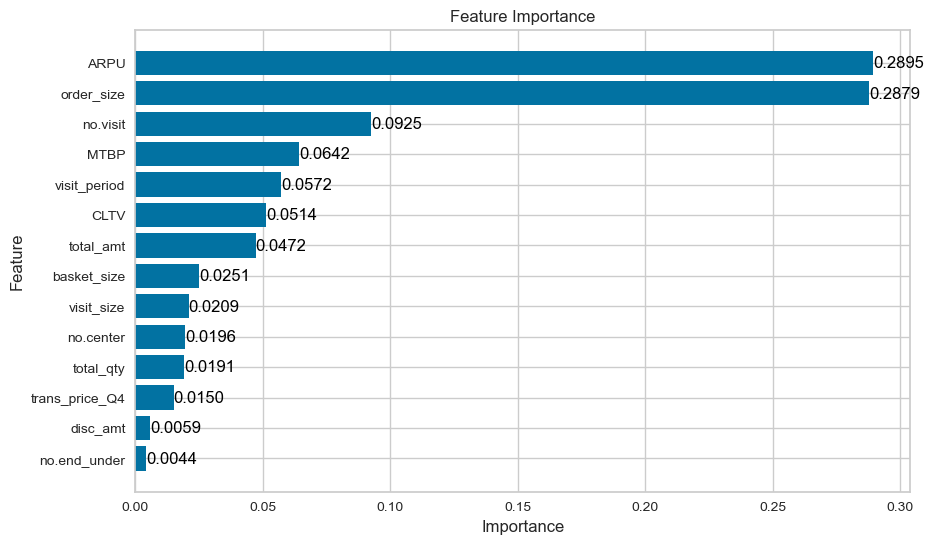

In [ ]:
import matplotlib.pyplot as plt

# classification model
def classification_model(clf, X_train, y_train, X_test, y_test, show_feature_importance=True):
    clf_model = clf.fit(X_train, y_train)
    y_hat_train = clf_model.predict(X_train)
    report_train = classification_report(y_train, y_hat_train)

    y_hat_test = clf_model.predict(X_test)
    report_test = classification_report(y_test, y_hat_test)

    print('Training Set Classification Report:')
    print(report_train)
    print('\n')

    print('Test Set Classification Report:')
    print(report_test)
    print('\n')

    if show_feature_importance:
        try:
            print('Standardized Coeff.')
            if hasattr(clf_model, 'coef_'):
                feature_importances = clf_model.coef_[0]
            elif hasattr(clf_model, 'feature_importances_'):
                feature_importances = clf_model.feature_importances_
            else:
                raise AttributeError("Model does not have attribute 'coef_' or 'feature_importances_'")

            coefficients = pd.DataFrame({"Feature": X_train.columns.tolist(), "Importance": feature_importances})
            coefficients = coefficients.sort_values(by="Importance", ascending=False)

            # Reverse sort order
            coefficients = coefficients[::-1]

            plt.figure(figsize=(10, 6))
            plt.barh(coefficients["Feature"], coefficients["Importance"])

            # Add data labels
            for i, v in enumerate(coefficients["Importance"]):
                plt.text(v, i, f"{v:.4f}", color='black', va='center')

            plt.xlabel("Importance")
            plt.ylabel("Feature")
            plt.title("Feature Importance")
            plt.show()
        except AttributeError as e:
            print(str(e))

# Random forest
rf_clf = RandomForestClassifier(max_depth=4, random_state=0)
classification_model(rf_clf, X_train_scaled, y_train, X_test_scaled, y_test)

### Customer segmentation result & recommended strategy

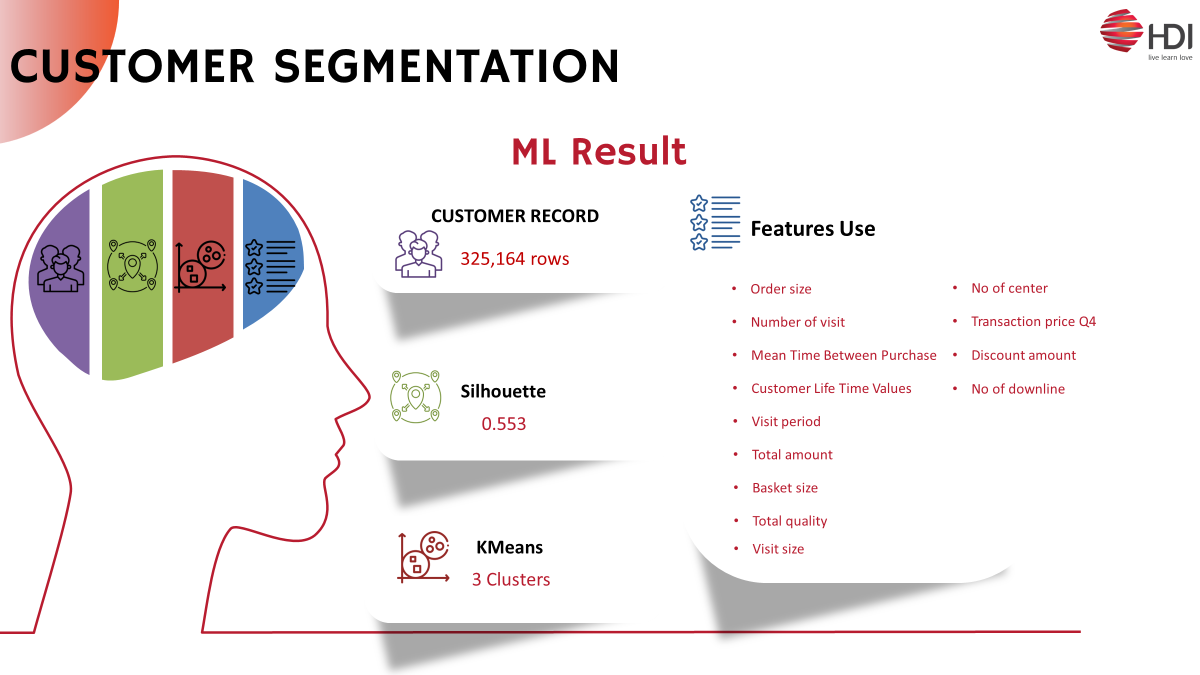

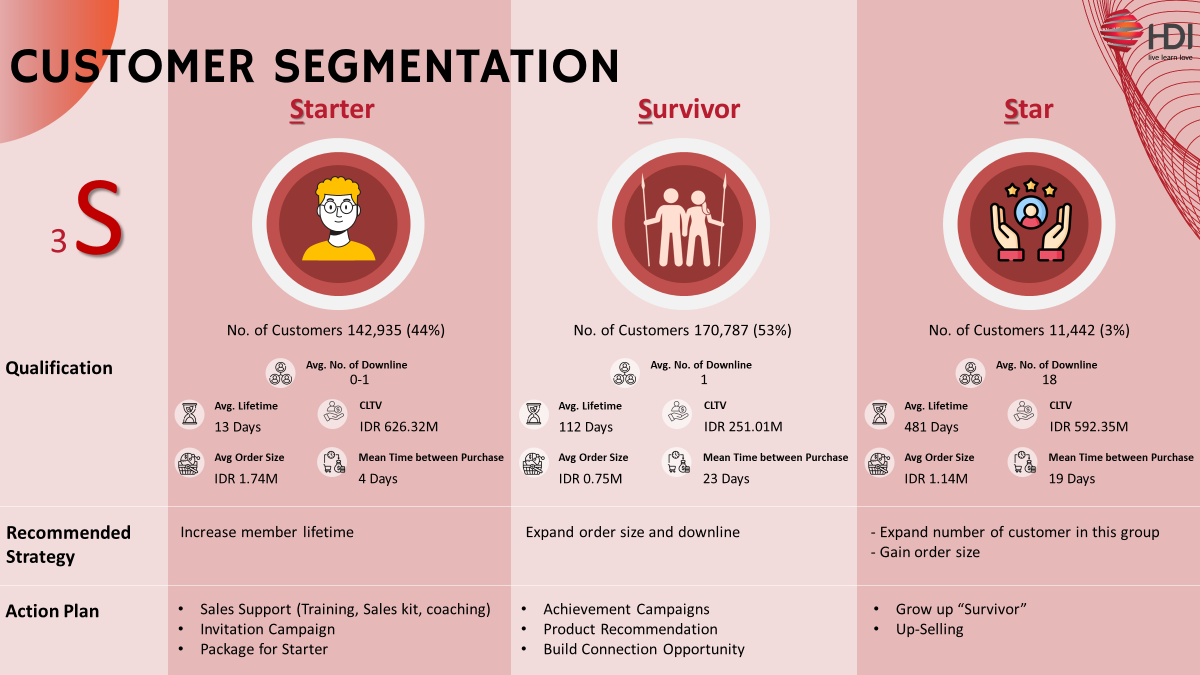